# Optimizacion Industrial con Computacion Evolutiva
<b> Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial</b>

Dr. Edwin Villanueva (ervillanueva@pucp.edu.pe)

## Asignación de vuelos a gates en aeropuerto

Esta  notebook implementa un algoritmo genético monoobjetivo para la resolución de la asignación de vuelos a gates. Los operadores de cruzamiento y mutación NO aseguran que los individuos representen vuelos diferentes y gates diferentes.

#### Representacion de Individuo:

Un objeto Individual representaa una determinada asignacion de un subconjunto de vuelos (almacenado en <b>list_of_flights</b>) a un conjunto de gates (almacenado en <b>chromosome</b>). La lista de gates disponibles que se pueden asignar a los vuelos se almacena en la variable <b>allele_pool</b>  del individuo. Ver el siguiente grafico ilustrativo:

<img src="EjemploIndividuoAvion.jpg">



In [ ]:
import sys
import time
import numpy as np
import random
from random import seed, randint, sample, uniform, randrange
from copy import deepcopy
import matplotlib.pyplot as plt

### Clase <b>Individual</b>

Esta es una clase para definir a un individuo de la población. Cada individuo posee un cromosoma, los vuelos a asignar, todos los posibles alelos y su respectivo fitness. Además, los métodos de esta clase permiten realizar el cruzamiento (crossover) y la mutación (mutation) sobre el cromosoma del individuo.

In [ ]:
# Clase que implementa el individuo y sus operadores
class Individual(object):

    # El constructor recibe la lista de vuelos que representa el individuo y los gates asignados, asi como el pool de flights y gates
    def __init__(self, flights, gates, flights_pool, gates_pool):
        self.flights = flights[:]
        self.gates = gates[:]
        self.flights_pool = flights_pool
        self.gates_pool = gates_pool
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = randrange(len(self.gates))  # escoge aleatoriamento una posicion en la lista gates

        gates_ind1 = self.gates[:c] + other.gates[c:]
        gates_ind2 = other.gates[:c] + self.gates[c:]

        while len(set(gates_ind1)) != len(gates_ind1):
          c = randrange(len(self.gates))
          gates_ind1 = self.gates[:c] + other.gates[c:]
        while len(set(gates_ind2)) != len(gates_ind2):
          c = randrange(len(self.gates))
          gates_ind2 = other.gates[:c] + self.gates[c:]

        ind1 = Individual(self.flights, self.gates[:c] + other.gates[c:], self.flights_pool, self.gates_pool)
        ind2 = Individual(self.flights, other.gates[:c] + self.gates[c:], self.flights_pool, self.gates_pool)
        return [ind1, ind2]

    def crossover_uniform(self, other):
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        gates_ind1 = []
        gates_ind2 = []

        for i in range(len(self.gates)):
            if uniform(0, 1) < 0.5:
                gates_ind1.append(self.gates[i])
                gates_ind2.append(other.gates[i])
            else:
                gates_ind1.append(other.gates[i])
                gates_ind2.append(self.gates[i])
        ind1 = Individual(self.flights, gates_ind1, self.flights_pool, self.gates_pool)
        ind2 = Individual(self.flights, gates_ind2, self.flights_pool, self.gates_pool)
        return [ind1, ind2]

    def flight_gate_crossover(self, other):
        while True:
            gates_ind1 = []
            gates_ind2 = []

            for i in range(len(self.gates)):
                if random.random() < 0.5:
                    gates_ind1.append(self.gates[i])
                    gates_ind2.append(other.gates[i])
                else:
                    gates_ind1.append(other.gates[i])
                    gates_ind2.append(self.gates[i])

            if len(set(gates_ind1)) == len(gates_ind1) and len(set(gates_ind2)) == len(gates_ind2):
                break

        ind1 = Individual(self.flights, gates_ind1, self.flights_pool, self.gates_pool)
        ind2 = Individual(self.flights, gates_ind2, self.flights_pool, self.gates_pool)

        return [ind1, ind2]

    def mutate_position(self):
        "Cambia aleatoriamente el Gate asignado a un Flight."
        mutated_gates = deepcopy(self.gates)
        indexGate = randrange(0, len(self.gates)) # escoje el indice del elemento de gates que sera mutado
        newGate = self.gates_pool[randrange(0, len(self.gates_pool))]

        while newGate in mutated_gates:
          newGate = self.gates_pool[randrange(0, len(self.gates_pool))]

        mutated_gates[indexGate] = newGate
        return Individual(self.flights, mutated_gates, self.flights_pool, self.gates_pool)

    def mutate_flight_gate(self):
        mutated_gates = deepcopy(self.gates)
        index_gate = randrange(0, len(mutated_gates))
        original_gate = mutated_gates[index_gate]
        new_gate = random.choice(self.gates_pool)

        while new_gate.identifier == original_gate.identifier or new_gate in mutated_gates:
            new_gate = random.choice(self.gates_pool)

        mutated_gates[index_gate] = new_gate

        if random.random() < 0.5:
            additional_index_gate = randrange(0, len(mutated_gates))
            additional_new_gate = random.choice(self.gates_pool)

            while additional_new_gate.identifier == mutated_gates[additional_index_gate] or additional_new_gate in mutated_gates:
                additional_new_gate = random.choice(self.gates_pool)

            mutated_gates[additional_index_gate] = additional_new_gate

        return Individual(self.flights, mutated_gates, self.flights_pool, self.gates_pool)

### Clase <b>Gate</b>

Esta es una clase abstracta para definir los lugares donde los vuelos serán asignados. Se debe hacer subclases con el fin de diferenciar los tipos de lugar donde un vuelo puede ser asignado.

In [ ]:
class Gate(object):
    def __init__(self, identifier, x, y, z):
        self.identifier = identifier   # identificador del Gate
        self.distance = x              # en el caso de Sleeve esto almacena la longitud de manga. En el caso de zonas es la distancia a una puerta del aeropuerto
        self.potential_of_speed = y    # en el caso de Sleeve esto almacena la velocidad de pasajeros en manga. En el caso de zona almacena la velocidad del bus
        self.number_of_persons_every_10m = z   # en el caso de Sleeve esto almacena el numero de personas cada 10 metros. En el cazo de zona es la capacidad del bus

    def __hash__(self):
        return self.identifier

### Clase <b>Sleeve</b>

Esta clase implementa concretamente el Gate tipo Sleeve (Manga). En este tipo de gate, los pasajeros deben realizar un recorrido a pie hasta abandonar totalmente el Gate. Se tiene en cuenta la longitud de la manga, la velocidad de los pasajeros y la cantidad de personas que pueden estar cada 10m (este valor es variable porque ya refleja el ancho de la manga, puesto que una manga más ancha permite una mayor cantidad de pasajeros).

In [ ]:
class Sleeve(Gate):
    def __init__(self, identifier, length_of_sleeve, speed_of_passengers_on_sleeve, number_of_passengers_every_10m):
        super().__init__(identifier, length_of_sleeve, speed_of_passengers_on_sleeve, number_of_passengers_every_10m)

### Clase <b>Zone</b>

Esta clase implementa concretamente el Gate tipo Zone (zona). En este tipo de gate, los pasajeros son recogidos por un bus y son llevados hasta una puerta. Se tiene en cuenta la distancia de la zona a la puerta, la velocidad y capacidad del bus.

In [ ]:
class Zone(Gate):
    def __init__(self, identifier, distance_zone_door, speed_bus, capacity_of_bus):
        super().__init__(identifier, distance_zone_door, speed_bus, capacity_of_bus)

### Clase <b>Flight</b>

Esta es una clase para definir a los vuelos a asignar. Cada vuelo posee una capacidad máxima, la cantidad de pasajeros, el tiempo de estacionamiento que le toma al vuelo, la longitud de las alas del avión, el tiempo de inspección al avión luego de aterrizar, el tiempo que demorarían en bajar las escaleras los pasajeros si el avión estuviera repleto, el momento de llegada al aeropuerto y el momento en que debería irse del aeropuerto.

In [ ]:
class Flight(object):
    def __init__(self, identifier, maximum_capacity, number_of_passengers, parking_time, length_wings, inspection_time, landing_time_on_stairs, arriving_time, leaving_time):
        self.identifier = identifier  # identificador de vuelo
        self.maximum_capacity = maximum_capacity  # maxima capacidad del vuelo
        self.number_of_passengers = number_of_passengers  # numero de pasajeros
        self.parking_time = parking_time   # tiempo de parqueo
        self.length_wings = length_wings   # longitud de las alas
        self.inspection_time = inspection_time  # tiempo de inspeccion
        self.landing_time_on_stairs = landing_time_on_stairs
        self.arriving_time = arriving_time   # tiempo de llegada al aeropuerto
        self.leaving_time = leaving_time   # tiempo de partida del aeropuerto

    def __hash__(self):
        return self.identifier

### Funciones utilitarias para generar los Gates y Vuelos</b>
Estas son funciones utilitarias para generar automáticamente los Gates y Vuelos

In [ ]:
# Genera una lista de Gates
def generate_list_of_gates(number_of_gates, max_length_of_sleeve=20, max_speed_of_passengers_on_sleeve=3, max_number_of_passengers_every_10m=12, max_distance_zone_door=50, max_speed_bus=15, max_capacity_of_bus=200):
  list_of_gates = list()

  for gate_identifier in range(number_of_gates):
    gate_type = randint(0, 1)

    if gate_type == 0:   # caso manga
      distance = randint(1, max_length_of_sleeve)
      potential_of_speed = randint(1, max_speed_of_passengers_on_sleeve)
      number_of_persons_every_10m = randint(1, max_number_of_passengers_every_10m)

      gate = Sleeve(gate_identifier, distance, potential_of_speed, number_of_persons_every_10m)

    else:    # caso zone
      distance = randint(1, max_distance_zone_door)
      potential_of_speed = randint(1, max_speed_bus)
      number_of_persons_every_10m = randint(1, max_capacity_of_bus)

      gate = Zone(gate_identifier, distance, potential_of_speed, number_of_persons_every_10m)

    list_of_gates.append(gate)

  return list_of_gates

# Genera una lista de Flights
def generate_list_of_flights(number_of_flights, max_maximum_capacity=100, max_number_of_passengers_factor=0.8, max_parking_time=30, max_length_wings=25, max_inspection_time=180, max_landing_time_on_stairs=60, max_arriving_time=200, max_leaving_time=1000):
  list_of_flights = list()

  max_number_of_passengers = max_number_of_passengers_factor * max_maximum_capacity

  for flight_identifier in range(number_of_flights):
    maximum_capacity = randint(max_number_of_passengers, max_maximum_capacity)
    number_of_passengers = randint(1, max_number_of_passengers)
    parking_time = randint(1, max_parking_time)
    length_wings = randint(1, max_length_wings)
    inspection_time = randint(1, max_inspection_time)
    landing_time_on_stairs = randint(1, max_landing_time_on_stairs)
    arriving_time = randint(1, max_arriving_time)
    leaving_time = randint(max_arriving_time + 1, max_leaving_time)

    flight = Flight(flight_identifier, maximum_capacity, number_of_passengers, parking_time, length_wings, inspection_time, landing_time_on_stairs, arriving_time, leaving_time)

    list_of_flights.append(flight)

  return list_of_flights

### Funciones utilitarias para ordenar los Vuelos y Gates</b>
Estas son funciones utilitarias para ordenar los Vuelos acorde a su deseabilidad y los Gates por su flujo personas

In [ ]:
# Funcion para ordenar vuelos por su grado de deseabilidad  ( nro_pasajeros/tiempo_en_aeropuerto )
def process_desirability(n):
  return n.number_of_passengers / (n.leaving_time - n.arriving_time)

# Funcion para ordenar Gates por su capacidad de flujo de personas
def process_flow(n):
  return n.number_of_persons_every_10m * n.potential_of_speed * 10 / n.distance

### Funciones utilitarias para el Algoritmo Genético</b>
Estas son funciones utilitarias para realizar el Algoritmo Genético que se encargue de la asignación de vuelos

In [ ]:
# Inicialización aleatoria de la población
def init_population(population_number, flights_to_assign, list_of_flights, list_of_gates):
  population = []
  for i in range(population_number):
    flights = sample(list_of_flights, flights_to_assign)  # escoge los vuelos del individuo
    gates = sample(list_of_gates, flights_to_assign) # escoge los gates del individuo

    while len(set(gates)) != len(gates):
            gates = sample(list_of_gates, flights_to_assign)

    population.append( Individual(flights, gates, list_of_flights, list_of_gates) )
  return population

In [ ]:
# Evalua una individuo representado por sus listas:  flights, gates
def fitness(flights, gates):
  grace_time = 5/100

  cumulative_efficiency = 0
  for flight, gate in zip(flights, gates):
    number_of_passengers = flight.number_of_passengers
    if isinstance(gate, Sleeve):  # si el gate es de tipo Manga
      disembarkation_time_of_passengers = ( (number_of_passengers * (gate.distance + flight.length_wings) / process_flow(gate)) + flight.parking_time + flight.inspection_time ) * (1 + grace_time)
    else:  # si el gate es de tipo Zona
      disembarkation_time_of_passengers = ( (number_of_passengers * gate.distance / process_flow(gate)) + flight.parking_time + (flight.landing_time_on_stairs * number_of_passengers / flight.maximum_capacity) + flight.inspection_time ) * (1 + grace_time)

    # la eficiencia de una asignacion flight-gate es la cantidad total de pasajeros desembarcados por unidad de tiempo
    cumulative_efficiency += number_of_passengers / disembarkation_time_of_passengers
  return cumulative_efficiency

In [ ]:
# Evaluar la población con la función fitness
def evaluate_population(population, fitness_fn):
  """ Evalua una poblacion de individuos con la funcion de fitness pasada """
  population_size = len(population)
  for i in range(population_size):
    if population[i].fitness == -1:    # Evalúa sólo si el individuo no esta evaluado
      population[i].fitness = fitness_fn(population[i].flights, population[i].gates)

In [ ]:
# Selección de padres por el método roulette
def select_parents_roulette(population):
    popsize = len(population)

    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness:
            iParent1 = i
            break

    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre
        cumfitness += population[i].fitness
        if cumfitness > pickfitness:
            iParent2 = i
            break
    return (population[iParent1], population[iParent2])

In [ ]:
# Selección de padres por el método de torneo
def select_parents_tournament(population, tournament_size):
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y1[i]].fitness)

    iParent1=np.argmax(list_indiv)

    # Escoje el segundo padre, desconsiderando el primer padre
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)

    return (population[x1[iParent1]],population[x2[iParent2]])

In [ ]:
# Selección de la nueva población con metodo de ranking
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []

    population.extend(offspring_population) # une las dos poblaciones
    survivors = sorted(population, key=lambda x: x.fitness, reverse=True)[:numsurvivors]
    next_population.extend(survivors)
    return next_population

### Algoritmo Genético

In [ ]:
def genetic_algorithm(list_of_flights, list_of_gates, num_individuals, flights_to_assign, fitness_fn, n_generations,
                      selection_fn="roulette", crossover="onepoint", mutation="position", p_mut=0.1):
  #seed(0)

  #Inicializa una poblacion inicial de forma aleatoria
  population = init_population(num_individuals, flights_to_assign, list_of_flights, list_of_gates)

  population_size = len(population)
  evaluate_population(population, fitness_fn)

  best_ind = sorted(population, key=lambda x: x.fitness, reverse=True)[0]  # mejor individuo
  bestfitness = [best_ind.fitness]  # guarda el fitness del mejor individuo
  print("Poblacion inicial, best_fitness = {}".format(best_ind.fitness))

  for g in range(n_generations): # ciclo evolutivo

    ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
    mating_pool = []
    for i in range(int(population_size/2)):
      if selection_fn == "roulette":
        mating_pool.append(select_parents_roulette(population))
      elif selection_fn == "tournament":
        mating_pool.append(select_parents_tournament(population, 3))  #torneo de tamaño 3
      else:
        raise NotImplementedError

    ## Crea la poblacion descendencia cruzando las parejas del mating pool
    offspring_population = []
    for i in range(len(mating_pool)):
      if crossover == "onepoint":
        offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) )
      elif crossover == "uniform":
        offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) )
      elif crossover == "flight_gate":
        offspring_population.extend( mating_pool[i][0].flight_gate_crossover(mating_pool[i][1]) )
      else:
        raise NotImplementedError

    ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
    for i in range(len(offspring_population)):
      if uniform(0, 1) < p_mut:
        if mutation == "position":
          offspring_population[i] = offspring_population[i].mutate_position()
        elif mutation == "flight_gate":
          offspring_population[i] = offspring_population[i].mutate_flight_gate()
        else:
          raise NotImplementedError

    ## Evalua la poblacion descendencia creada
    evaluate_population(offspring_population, fitness_fn)

    ## Selecciona individuos para la sgte. generación con el metodo de ranking
    population = select_survivors_ranking(population, offspring_population, population_size) #metodo de ranking

    ## Almacena la historia del fitness del mejor individuo
    best_ind = sorted(population, key=lambda x: x.fitness, reverse=True)[0]  # mejor individuo de la poblacion actual
    bestfitness.append(best_ind.fitness)

    if (g % 10 == 0):  # muestra resultados cada 10 generaciones
      print("generacion {}, (Mejor fitness = {})".format(g, best_ind.fitness))

  return best_ind, bestfitness  # devuelve el mejor individuo y la lista de mejores fitness x gen

### Funciones utilitarias para manejar la solución del Algoritmo Genético</b>
Esta es una función utilitarias que permite mostrar la configuración usada en el Algoritmo Genético y la asignación de Vuelos a Gates encontrada en un individuo pasado (ind)

In [ ]:
def make_solution_report(ind, selection_fn, crossover, mutation):
  print("Selection: {} - Crossover: {} - Mutation: {} - Fitness: {}".format(selection_fn, crossover, mutation, ind.fitness), flush=True)
  print(" - ".join(["Flight {} in {} {}".format(flight.identifier, "Zone" if isinstance(gate, Zone) == True else "Sleeve", gate.identifier) for flight, gate in zip(ind.flights, ind.gates)]) + "\n", flush=True)

## <b>Probando el Algoritmo Genético</b>

### <b>Generación de Gates y Vuelos</b>

Genera los Gates y Vuelos para que el Algoritmo Genético  realize la asignacion. Asegura que el numero de vuelos a asignar (**flights_to_assign**) no sea mayor a la cantidad de puertas

In [ ]:
seed(0)

number_of_gates = 7
number_of_flights = 30

# general los vuelos y gates
list_of_gates = generate_list_of_gates(number_of_gates)
list_of_flights = generate_list_of_flights(number_of_flights)

# obtiene el numero de vuelos que el algoritmo genetico puede asignar (no puede ser mayor al numero de gates disponibles)
flights_to_assign = number_of_flights if number_of_flights <= number_of_gates	else number_of_gates

# ordena los vuelos por su deseabilidad y los gates por su capacidad de flujo de personas
list_of_flights = sorted(list_of_flights, key=process_desirability, reverse=True)
list_of_gates = sorted(list_of_gates, key=process_flow, reverse=True)

### <b>Experimentación con el Algoritmo Genético</b>

Poblacion inicial, best_fitness = 2.660462008814212
generacion 0, (Mejor fitness = 2.660462008814212)
generacion 10, (Mejor fitness = 3.676333152640053)
generacion 20, (Mejor fitness = 3.7147081440609537)
generacion 30, (Mejor fitness = 3.7147081440609537)
generacion 40, (Mejor fitness = 3.7147081440609537)


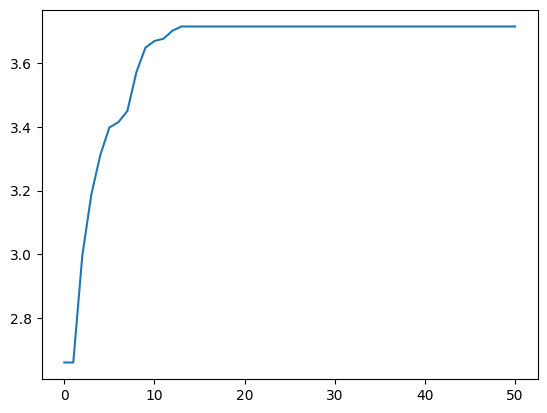

Selection: roulette - Crossover: uniform - Mutation: position - Fitness: 3.7147081440609537
Flight 1 in Zone 2 - Flight 3 in Zone 2 - Flight 23 in Zone 2 - Flight 15 in Zone 2 - Flight 27 in Sleeve 4 - Flight 14 in Sleeve 4 - Flight 9 in Sleeve 4



In [ ]:
num_individuals = 50

fitness_fn = fitness
n_generations = 50

best_fitness = 0

selection_fn = "roulette"
crossover = "uniform"
mutation = "position"
p_mut = 0.2

# Realiza la asignacion con el algoritmo genetico
best_ind, bestfitness = genetic_algorithm(list_of_flights, list_of_gates, num_individuals, flights_to_assign, fitness_fn, n_generations, selection_fn, crossover, mutation, p_mut)

# muestra la evolucion del mejor fitness
plt.plot(bestfitness)
plt.show()

# imprime la mejor solucion
make_solution_report(best_ind, selection_fn, crossover, mutation)

## Taller

###Sin mutación

In [ ]:
number_of_flights = 30
number_of_gates = 10

list_of_gates = generate_list_of_gates(number_of_gates)
list_of_flights = generate_list_of_flights(number_of_flights)

Poblacion inicial, best_fitness = 3.5147583539063865
generacion 0, (Mejor fitness = 3.5147583539063865)
generacion 10, (Mejor fitness = 4.962716482708619)
generacion 20, (Mejor fitness = 4.962716482708619)
generacion 30, (Mejor fitness = 4.962716482708619)
generacion 40, (Mejor fitness = 4.962716482708619)
Selection: roulette - Crossover: flight_gate - Mutation: No Mutation - Fitness: 4.962716482708619
Flight 5 in Zone 9 - Flight 2 in Zone 0 - Flight 13 in Sleeve 2 - Flight 23 in Zone 3 - Flight 0 in Zone 7 - Flight 10 in Zone 1 - Flight 7 in Sleeve 6

Poblacion inicial, best_fitness = 3.482652606420446
generacion 0, (Mejor fitness = 3.482652606420446)
generacion 10, (Mejor fitness = 4.690486403669126)
generacion 20, (Mejor fitness = 4.690486403669126)
generacion 30, (Mejor fitness = 4.690486403669126)
generacion 40, (Mejor fitness = 4.690486403669126)
Selection: roulette - Crossover: flight_gate - Mutation: No Mutation - Fitness: 4.690486403669126
Flight 26 in Zone 0 - Flight 2 in Zon

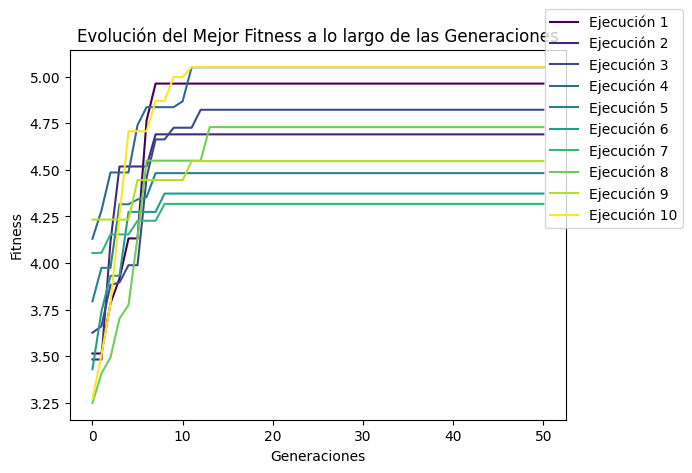

In [ ]:
p_mut = 0  # Sin mutación

all_fitness = []

colors = plt.cm.viridis(np.linspace(0, 1, 10))

for i in range(10):
    best_ind, best_fitness = genetic_algorithm(
        list_of_flights, list_of_gates, num_individuals, flights_to_assign,
        fitness_fn, n_generations, selection_fn, "flight_gate", None, p_mut
    )

    make_solution_report(best_ind, selection_fn, "flight_gate", "No Mutation")

    all_fitness.append(best_fitness)
    plt.plot(best_fitness, color=colors[i], label=f'Ejecución {i+1}')

plt.title('Evolución del Mejor Fitness a lo largo de las Generaciones')
plt.xlabel('Generaciones')
plt.ylabel('Fitness')

plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0.5))

plt.show()

###Con mutación

In [ ]:
number_of_flights = 30
number_of_gates = 10

list_of_gates = generate_list_of_gates(number_of_gates)
list_of_flights = generate_list_of_flights(number_of_flights)

Poblacion inicial, best_fitness = 4.659255795068231
generacion 0, (Mejor fitness = 4.802112624563227)
generacion 10, (Mejor fitness = 5.709096354989219)
generacion 20, (Mejor fitness = 5.751910069649628)
generacion 30, (Mejor fitness = 5.756528661808636)
generacion 40, (Mejor fitness = 5.764744556689548)
Selection: roulette - Crossover: flight_gate - Mutation: Mutation Rate 0.3 - Fitness: 5.764744556689548
Flight 21 in Zone 9 - Flight 12 in Zone 9 - Flight 20 in Zone 9 - Flight 17 in Zone 9 - Flight 22 in Zone 9 - Flight 14 in Zone 9 - Flight 10 in Zone 9

Poblacion inicial, best_fitness = 4.430206311339868
generacion 0, (Mejor fitness = 5.067621277800258)
generacion 10, (Mejor fitness = 6.338840650291921)
generacion 20, (Mejor fitness = 6.467475043242274)
generacion 30, (Mejor fitness = 6.487169405769638)
generacion 40, (Mejor fitness = 6.487169405769638)
Selection: roulette - Crossover: flight_gate - Mutation: Mutation Rate 0.3 - Fitness: 6.487169405769638
Flight 10 in Zone 9 - Fligh

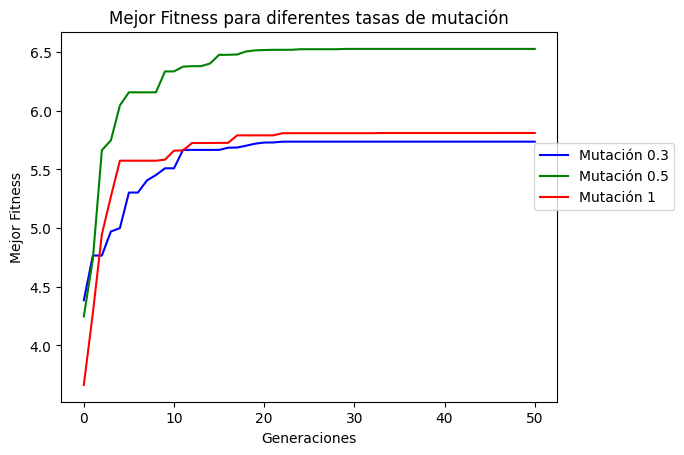

In [ ]:
mutation_rates = [0.3, 0.5, 1]
colors = ['blue', 'green', 'red']

for mutation_rate, color in zip(mutation_rates, colors):
    best_overall_fitness = []

    for i in range(10):
        best_ind, best_fitness = genetic_algorithm(
            list_of_flights, list_of_gates, num_individuals, flights_to_assign,
            fitness_fn, n_generations, selection_fn, "flight_gate", "flight_gate", mutation_rate
        )
        best_overall_fitness.append(max(best_fitness))
        make_solution_report(best_ind, selection_fn, "flight_gate", f"Mutation Rate {mutation_rate}")

    plt.plot(best_fitness, color=color, label=f'Mutación {mutation_rate}')

plt.title('Mejor Fitness para diferentes tasas de mutación')
plt.xlabel('Generaciones')
plt.ylabel('Mejor Fitness')

plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0.5))

plt.show()

###NSGA-II

In [ ]:
class NSGAII:
    def __init__(self, list_of_flights, list_of_gates, num_individuals, flights_to_assign, n_generations, p_mut):
        self.list_of_flights = list_of_flights
        self.list_of_gates = list_of_gates
        self.num_individuals = num_individuals
        self.flights_to_assign = flights_to_assign
        self.n_generations = n_generations
        self.p_mut = p_mut

    def init_population(self):
        population = []
        for _ in range(self.num_individuals):
            flights = random.sample(self.list_of_flights, self.flights_to_assign)
            gates = random.sample(self.list_of_gates, self.flights_to_assign)
            population.append(Individual(flights, gates, self.list_of_flights, self.list_of_gates))
        return population

    def evaluate_population(self, population):
        for ind in population:
            if ind.fitness == -1:
                fitness_a = sum(flight.number_of_passengers for flight in ind.flights)
                fitness_b = self.calculate_disembarkation_time(ind.flights, ind.gates)
                ind.fitness = (fitness_a, fitness_b)


    def calculate_disembarkation_time(self, flights, gates):
        total_time = 0
        for flight, gate in zip(flights, gates):
            if isinstance(gate, Sleeve):
                disembarkation_time = ((flight.number_of_passengers * (gate.distance + flight.length_wings) / process_flow(gate))
                                       + flight.parking_time + flight.inspection_time)
            else:
                disembarkation_time = ((flight.number_of_passengers * gate.distance / process_flow(gate))
                                       + flight.parking_time + (flight.landing_time_on_stairs * flight.number_of_passengers / flight.maximum_capacity)
                                       + flight.inspection_time)
            total_time += disembarkation_time
        return total_time

    def build_offspring_population(self, population):
        offspring = []
        for _ in range(int(len(population) / 2)):
            parent1, parent2 = self.select_parents(population)
            offspring.extend(parent1.flight_gate_crossover(parent2))
        return offspring

    def select_parents(self, population):
        tournament_size = 3
        selected = random.sample(population, tournament_size)
        parent1 = min(selected, key=lambda x: x.fitness[1])
        selected = random.sample(population, tournament_size)
        parent2 = min(selected, key=lambda x: x.fitness[1])
        return parent1, parent2

    def build_next_population(self, combined_population):
        pareto_fronts = self.non_dominated_sort(combined_population)
        new_population = []
        for front in pareto_fronts:
            if len(new_population) + len(front) > self.num_individuals:
                new_population.extend(random.sample(front, self.num_individuals - len(new_population)))
                break
            new_population.extend(front)
        return new_population

    def non_dominated_sort(self, population):
        pareto_fronts = []
        pareto_front = []
        for ind in population:
            ind.dominated_solutions = 0
            ind.dominates = []
            for other in population:
                if self.dominates(ind, other):
                    ind.dominates.append(other)
                elif self.dominates(other, ind):
                    ind.dominated_solutions += 1
            if ind.dominated_solutions == 0:
                pareto_front.append(ind)
        pareto_fronts.append(pareto_front)

        while pareto_front:
            new_front = []
            for ind in pareto_front:
                for dominated in ind.dominates:
                    dominated.dominated_solutions -= 1
                    if dominated.dominated_solutions == 0:
                        new_front.append(dominated)
            pareto_front = new_front
            if pareto_front:
                pareto_fronts.append(pareto_front)
        return pareto_fronts

    def dominates(self, ind1, ind2):
        return all(f1 <= f2 for f1, f2 in zip(ind1.fitness, ind2.fitness)) and any(f1 < f2 for f1, f2 in zip(ind1.fitness, ind2.fitness))

    def get_paretofront_population(self, population):
        """
        Obtiene la población de individuos que conforman la frontera de Pareto
        a partir de la población dada.
        """
        population = deepcopy(population)
        pop_size = len(population)

        pareto_front = np.ones(pop_size, dtype=bool)

        for i in range(pop_size):
            for j in range(pop_size):
                if all(np.asarray(population[j].fitness) >= np.asarray(population[i].fitness)) and any(np.asarray(population[j].fitness) > np.asarray(population[i].fitness)):
                    pareto_front[i] = 0
                    break

        paretofront_population = [population[i] for i in range(pop_size) if pareto_front[i] == 1]

        return paretofront_population

    def genetic_algorithm(self):
        P = self.init_population()
        self.evaluate_population(P)

        for g in range(self.n_generations):
            Q = self.build_offspring_population(P)
            self.evaluate_population(Q)
            P.extend(Q)
            P = self.build_next_population(P)

        return self.get_paretofront_population(P)

####Pareto

In [ ]:
number_of_flights = 30
number_of_gates = 10

list_of_gates = generate_list_of_gates(number_of_gates)
list_of_flights = generate_list_of_flights(number_of_flights)

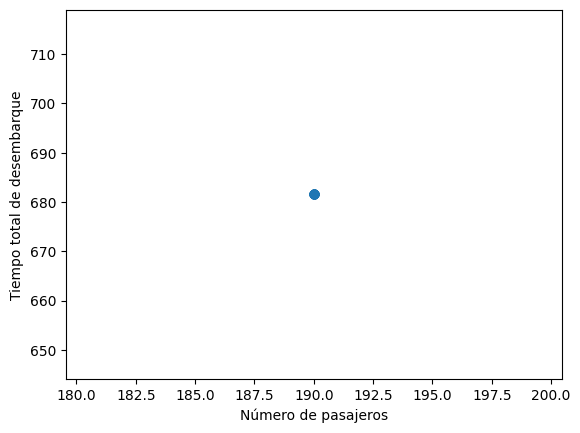

In [ ]:
flights_to_assign = min(flights_to_assign, number_of_flights, number_of_gates)

nsga = NSGAII(list_of_flights, list_of_gates, num_individuals=50, flights_to_assign=flights_to_assign, n_generations=100, p_mut=0.1)
pareto_front = nsga.genetic_algorithm()

pop_size = len(pareto_front)
num_objectives = len(pareto_front[0].fitness)
fitnesses = np.array([ind.fitness for ind in pareto_front])

x = fitnesses[:, 0]
y = fitnesses[:, 1]

plt.xlabel('Número de pasajeros')
plt.ylabel('Tiempo total de desembarque')
plt.scatter(x, y)
plt.show()